
Knowing the distance to coastline for an exposure is crucial for insurance rating applications because it helps insurers assess the risk of hazards like hurricanes, storm surges, and flooding, which are much more prevalent in coastal areas. This information allows insurers to make informed decisions about pricing, underwriting and reinsurance. Properties closer to the coast are generally at higher risk, leading to higher premiums for these properties. Insurance rating plans may use distance to coastline directly as an explanatory variable, with factors inversely proportional to distance to coastline. 

This article walks through how GeoPandas can be used to calculate distance to coastline for a collection of simulated latitude-longitude pairs in the Florida region, and how these exposure locations can be assigned to different risk levels based on the distance calculation. 

<br>


### Coastal Shapefiles

The United States Census Bureau provides shapefiles for state, county and ZCTA boundaries as well as roads, rails an coastlines (see full list [here](https://www2.census.gov/geo/tiger/TIGER2024/2024_TL_Shapefiles_File_Name_Definitions.pdf)). Shapefiles are a widely-used geospatial vector data format that store the geometric location and attribute information of geographic features, which can be represented as points, lines, or polygons. 


We being by downloading the COASTLINE zip archive available on the Census Bureau's [FTP site](https://www2.census.gov/geo/tiger/TIGER2024/COASTLINE/). The COASTLINE shapefile is loaded into GeoPandas (the STATE shapefile is also loaded for later use). We limit our analysis to the continental United States and filter out the Great Lakes. Inspecting the first few records:



In [1]:

import numpy as np
import pandas as pd
import geopandas as gpd

np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


coastline_shp = "tl_2024_us_coastline.zip"
us_shp = "tl_2024_us_state.zip"


# Bounding box of lower 48 states. Remove Great Lakes.
xmin, ymin, xmax, ymax = -125, 24.6, -65, 50
coast = gpd.read_file(coastline_shp)
coast = coast.cx[xmin:xmax, ymin:ymax]
coast = coast[coast.NAME!="Great Lakes"].reset_index(drop=True)

# State boundaries.
states = gpd.read_file(us_shp)[["NAME", "geometry"]]
states = states.cx[xmin:xmax, ymin:ymax].reset_index(drop=True)

print(f"coast.shape : {coast.shape}")
print(f"states.shape: {states.shape}")

coast.head(10)


coast.shape : (2916, 3)
states.shape: (49, 2)


,NAME,MTFCC,geometry
0,Atlantic,L4150,"LINESTRING (-80.88368 32.03912, -80.88365 32.0..."
1,Atlantic,L4150,"LINESTRING (-70.66800 41.51199, -70.65663 41.5..."
2,Atlantic,L4150,"LINESTRING (-76.58108 38.09572, -76.58184 38.0..."
3,Atlantic,L4150,"LINESTRING (-73.75518 40.58565, -73.75517 40.5..."
4,Atlantic,L4150,"LINESTRING (-76.15615 38.63324, -76.15070 38.6..."
5,Atlantic,L4150,"LINESTRING (-76.53289 39.20776, -76.53298 39.2..."
6,Atlantic,L4150,"LINESTRING (-73.93653 40.56644, -73.93594 40.5..."
7,Atlantic,L4150,"LINESTRING (-81.10208 29.42706, -81.10215 29.4..."
8,Atlantic,L4150,"LINESTRING (-71.89236 41.32922, -71.89293 41.3..."
9,Atlantic,L4150,"LINESTRING (-75.31239 38.94595, -75.31239 38.9..."



<br>

The coastline shapefile is comprised of ~3,000 LINESTRING objects. Let's get a count of geometries by NAME:

In [2]:

coast["NAME"].value_counts().sort_index()


NAME
Atlantic     941
Gulf         647
Pacific     1328
Name: count, dtype: int64


<br>


<br> 

We can visualize the coastline by calling the `coast` GeoDataFrame's `plot` method:


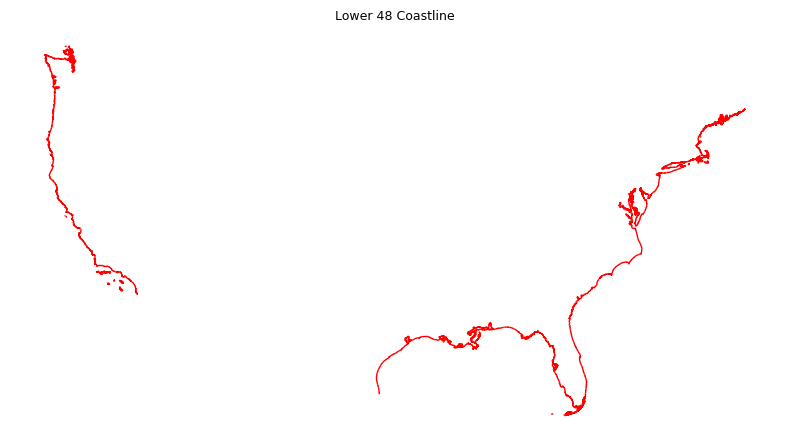

In [3]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
ax.set_title("Lower 48 Coastline", fontsize=9)
coast.plot(ax=ax, edgecolor="red", linewidth=1.0)
ax.axis("off")
plt.show()



<br> 

To overlay the coastline along with state boundaries, download the STATE shapefile from the Census Bureau's FTP site and plot them together:

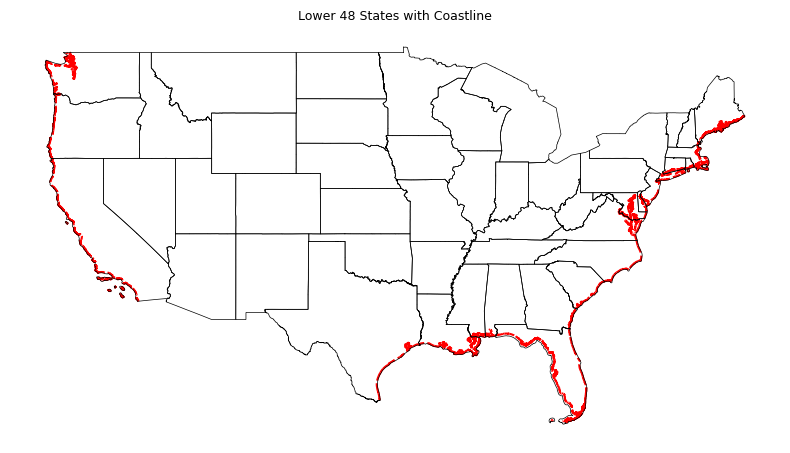

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
ax.set_title("Lower 48 States with Coastline", fontsize=9)
coast.plot(ax=ax, edgecolor="red", linewidth=1.50, linestyle="--")
states.boundary.plot(ax=ax, edgecolor="black", linewidth=0.50)
ax.axis("off")
plt.show()


<br>

Let's next generate synthetic latitude-longitude pairs from within the Florida bounding envelope. The envelope bounds can be obtained from Florida's geometry as follows:

In [5]:


# Get bounding box for each state.
states["bbox"] = states.geometry.map(lambda gg: gg.envelope.bounds)

# Put coordinates in separate columns.
states[["lon0", "lat0", "lon1", "lat1"]] = pd.DataFrame(states.bbox.tolist(), index=states.index)

states.head()


,NAME,geometry,bbox,lon0,lat0,lon1,lat1
0,West Virginia,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...","(-82.644591, 37.20154, -77.719519, 40.638801)",-82.644591,37.201540,-77.719519,40.638801
1,Florida,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...","(-87.634896, 24.396308, -79.974306, 31.000968)",-87.634896,24.396308,-79.974306,31.000968
2,Illinois,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...","(-91.513079, 36.970298, -87.019935, 42.508481)",-91.513079,36.970298,-87.019935,42.508481
3,Minnesota,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...","(-97.239093, 43.499361, -89.483385, 49.384479)",-97.239093,43.499361,-89.483385,49.384479
4,Maryland,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...","(-79.487651, 37.886605, -74.986282, 39.723037)",-79.487651,37.886605,-74.986282,39.723037



<br>



Let's draw the bounding region using folium:



In [6]:

import folium 

# Florida bounding box. 
lon0, lat0, lon1, lat1 = states[states.NAME=="Florida"].bbox.item()

mlat, mlon = (lat0 + lat1) / 2, (lon0 + lon1) / 2

m = folium.Map(
    location=[mlat, mlon], 
    zoom_start=6, 
    zoom_control=True, 
    no_touch=True,
    tiles="OpenStreetMap"
    )

folium.Rectangle(
    [(lat0, lon0), (lat1, lon1)], 
    fill_color="blue", fill_opacity=.05
    ).add_to(m)

m



<br>

Sampling from the bounding region highlighted above will result in many points in the Gulf. Let's narrow the sampling space:

In [7]:

lon0, lat0, lon1, lat1 = (-80.5, 26, -81.75, 28)

mlat, mlon = (lat0 + lat1) / 2, (lon0 + lon1) / 2

m = folium.Map(
    location=[mlat, mlon], 
    zoom_start=7, 
    zoom_control=True, 
    no_touch=True,
    tiles="OpenStreetMap"
    )

folium.Rectangle(
    [(lat0, lon0), (lat1, lon1)], 
    fill_color="blue", fill_opacity=.05
    ).add_to(m)

m

In [8]:

# Sample within bounds defined by lat0, lon0, lat1, lon1. 

nbr_locations = 50

rng = np.random.default_rng(516)

rlats = rng.uniform(low=lat0, high=lat1, size=nbr_locations)
rlons = rng.uniform(low=lon1, high=lon0, size=nbr_locations)
points = list(zip(rlats, rlons))



<br>


Visualizing the synthetic locations:


In [9]:

m = folium.Map(location=[mlat, mlon], zoom_start=8)

for lat, lon in points:

    folium.CircleMarker(
        location=[lat, lon], 
        radius=5, 
        color="red", 
        fill_color="red", 
        fill=True,
        fill_opacity=1
        ).add_to(m)

m



<br>

Next the `points` list needs to be represented as a GeoDataFrame, using the generated points as the geometry. We set `"crs=EPSG:4326"` representing longitude-latitude pairs. A policy_id is included as an identifier for each point. 


In [10]:

dfpoints = pd.DataFrame({
    "policy_id": [str(ii).zfill(7) for ii in range(len(points))],
    "lat": rlats, 
    "lon": rlons, 
})

# Create GeoDataFrame.
points = gpd.GeoDataFrame(
    dfpoints,
    geometry=gpd.points_from_xy(dfpoints.lon, dfpoints.lat),
    crs="EPSG:4326"
)

points.head(10)


,policy_id,lat,lon,geometry
0,0000000,26.158425,-81.697845,POINT (-81.69785 26.15842)
1,0000001,27.308367,-80.743510,POINT (-80.74351 27.30837)
2,0000002,26.050160,-81.226294,POINT (-81.22629 26.05016)
3,0000003,26.896432,-80.682348,POINT (-80.68235 26.89643)
4,0000004,27.407736,-81.556209,POINT (-81.55621 27.40774)
5,0000005,26.551877,-80.902803,POINT (-80.90280 26.55188)
6,0000006,26.301071,-81.521000,POINT (-81.52100 26.30107)
7,0000007,27.435718,-81.499145,POINT (-81.49914 27.43572)
8,0000008,27.784378,-80.590765,POINT (-80.59076 27.78438)
9,0000009,27.635399,-81.389836,POINT (-81.38984 27.63540)



<br>

With both the coastline shapefile and point data represented as GeoDataFrames, we execute the `sjoin_nearest` spatial join to get the distance from each point to the nearest coastline. First we need to set the crs to a projected coordinate system so the distances are returned in units of meters instead of degrees. Projected coordinate systems use linear units like meters or feet, which makes it easier to perform precise spatial measurements. Here we opt for the Conus Albers equal area conic projection (EPSG:5069).

In the call to `sjoin_nearest`, we specify "meters" for the `distance_col` argument. This column will hold the distance to the coastline for each point in `points` in units of meters. A miles column is added after the join. 


In [11]:

# Convert from GPS to  Conus Albers. 
points = points.to_crs("EPSG:5069")
coast = coast.to_crs("EPSG:5069")

# Perform spatial join. Covert meters to miles. 
gdf = gpd.sjoin_nearest(points, coast, how="left", distance_col="meters")
gdf["miles"] = gdf["meters"] * 0.000621371

# Get min, max and average distance to coast line.
min_dist = gdf.miles.min()
max_dist = gdf.miles.max()
avg_dist = gdf.miles.mean()

print(f"min. distance to coastline: {min_dist}")
print(f"max. distance to coastline: {max_dist}")
print(f"avg. distance to coastline: {avg_dist}")


min. distance to coastline: 0.20197535859716287
max. distance to coastline: 65.35183791451661
avg. distance to coastline: 35.26215239057489



<br>

### Rate Group Based on Distance to Coastline

Let's imagine a hypothetical rating plan that uses the following distances from the coastline to determine rates:

* 0 - 5 miles: very high risk
* 5 - 25 miles: high risk
* 25 - 50 miles: medium risk
* greater than 50 miles: low risk

<br>

A rolling join via `merge_asof` can be used to select the last row in the right DataFrame (group thresholds) whose `on` key is less than or equal to `gdf`'s key, which will be "miles" in both DataFrames.  

In [12]:

# Create dfgroups DataFrame. 
dfgroups = pd.DataFrame({
    "risk": ["very high", "high", "medium", "low"],
    "miles": [0., 5., 25., 50.]
})

# Assign risk group to each policy location.
gdf = gdf.sort_values("miles", ascending=True)
gdf = pd.merge_asof(gdf, dfgroups, on="miles", direction="backward")

gdf.head(10)


,policy_id,lat,lon,geometry,index_right,NAME,MTFCC,meters,miles,risk
0,0000016,27.972984,-80.506574,POINT (1523126.311 669355.565),176,Atlantic,L4150,325.047932,0.201975,very high
1,0000000,26.158425,-81.697845,POINT (1436901.833 453402.683),2813,Gulf,L4150,11201.767881,6.960454,high
2,0000015,26.383000,-81.709033,POINT (1432089.414 477631.030),2817,Gulf,L4150,14922.894431,9.272654,high
3,0000045,26.189330,-81.661985,POINT (1439966.962 457301.849),2813,Gulf,L4150,15292.789125,9.502496,high
4,0000008,27.784378,-80.590765,POINT (1518283.776 647462.840),211,Atlantic,L4150,16412.307856,10.198132,high
5,0000037,26.366454,-81.662935,POINT (1436947.116 476528.844),2813,Gulf,L4150,18665.871130,11.598431,high
6,0000030,27.473270,-80.505108,POINT (1532219.823 614970.878),10,Atlantic,L4150,20055.344308,12.461809,high
7,0000017,26.086354,-81.489777,POINT (1458848.059 448748.018),2813,Gulf,L4150,24280.862758,15.087424,high
8,0000044,27.226453,-80.508471,POINT (1536305.431 588071.282),10,Atlantic,L4150,29966.032034,18.620023,high
9,0000006,26.301071,-81.521000,POINT (1452153.395 471583.300),2813,Gulf,L4150,30913.531896,19.208772,high



<br> 

Counting the number of policies per risk group:

In [13]:

gdf.risk.value_counts().sort_index()


risk
high         12
low          10
medium       27
very high     1
Name: count, dtype: int64


<br>

Finally, we can assign each risk a different color and visualize the resulting risk groups with folium:


In [14]:

# Colors for each group.
dcolors = {
    "very high": "#f40002",
    "high": "#ff721f",
    "medium": "#fafc15",
    "low": "#268a6d"
}

gdf["color"] = gdf["risk"].map(dcolors)

m = folium.Map(location=[mlat, mlon], zoom_start=8)

for tt in gdf.itertuples():
    lat, lon, color = tt.lat, tt.lon, tt.color
    folium.CircleMarker(
        location=[lat, lon],
        radius=6, 
        color=color, 
        fill_color=color, 
        fill=True,
        fill_opacity=1
        ).add_to(m)

m



<br>
